## Description
In this notebook, we do a basic exploration of MSI data sets. We detect outlying signals, in both the spatial domain (pixels with atypical spectra) and mz domain (mz values with atypical distribution of intensities over the image).   
Then, we centroid the images and save the results.   
Most of this notebook is applicable to MSI data sets in profile mode. If your data set is already centroided, you may skip to the next notebook.     

In [1]:
%matplotlib notebook

In [2]:
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from path import Path

In [3]:
from spatialstein.data_preprocessing import get_msi_shape, shift_coordinates

Set the path to your folder with MSI data sets here:

In [4]:
# USER INPUT
DATA_FOLDER = Path('Data')

Set the path to the folder to output results. You may need to create an empty folder manually.  

In [5]:
# USER INPUT
OUTPUT_FOLDER = Path('Preprocessed data')

Input the filenames of the imzML files in `msi_filenames`.   
Create identifiable names of the data sets in `msi_names`.    

In [6]:
# USER INPUT
msi_filenames = ['HR2MSI mouse urinary bladder S096.imzML', 'test_POS.imzML']
msi_names = ['mouse bladder', 'mouse cerebellum']

The cell below will load the data.   
The pixel coordinates will be shifted so that the first pixel has a coordinate (0, 0).  

In [7]:
msi_datasets = {}
dataset_shapes = {}
for name, filename in zip(msi_names, msi_filenames):
    dset = ImzMLParser(DATA_FOLDER / filename)
    shift_coordinates(dset)   
    shape = get_msi_shape(dset)
    msi_datasets[name] = dset
    dataset_shapes[name] = shape
    print('Loaded data set', filename)
    print('Shape:', shape)
    print('Number of pixels:', shape[0]*shape[1])

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(


Loaded data set HR2MSI mouse urinary bladder S096.imzML
Shape: (134, 260)
Number of pixels: 34840
Loaded data set test_POS.imzML
Shape: (21, 81)
Number of pixels: 1701


/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mzML file". Updating name to "mzML format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000615 found with incorrect name "ProteoWizard". Updating name to "ProteoWizard software".
  warn(


In [8]:
msi_datasets['mouse cerebellum'].metadata.pretty()

{'file_description': {'type': 'fileContent',
  'MS1 spectrum': True,
  'processed': True,
  'universally unique identifier': '7e57164007e544cbb10764bd5dcd4b3a',
  'ibd SHA-1': '6ae3c58853dd8a8f9573fa553baffcdaf8f60118',
  'source_files': {'RAW1': {'type': 'sourceFile',
    'id': 'RAW1',
    'location': 'file:///D:\\MALDI data\\Emma',
    'name': '010615_Twitcher_cer_THAP_15L_pos_TI.raw',
    'Thermo nativeID format': True,
    'Thermo RAW format': True,
    'SHA-1': '36600785e8fb5a2e8cad0dc22830c3835389f2fb'},
   'mzML0': {'type': 'sourceFile',
    'id': 'mzML0',
    'location': 'file:/D:/MALDI%20data/Emma/',
    'name': '010615_Twitcher_cer_THAP_15L_pos_TI.mzML',
    'Thermo nativeID format': True,
    'mzML format': True}},
  'contacts': []},
 'referenceable_param_groups': {'CommonInstrumentParams': {'type': 'referenceableParamGroup',
   'id': 'CommonInstrumentParams',
   'LTQ Orbitrap XL': True,
   'instrument serial number': 'SN01829B'},
  'mzArray': {'type': 'referenceableParamGro

# Basic data exploration

In [9]:
from spatialstein.data_exploration import calculate_TIC_array

Total Ion Current plots:

In [10]:
tic_arrays = {name: calculate_TIC_array(msi_datasets[name], is_profile_mode = True) for name in msi_names}

<IPython.core.display.Javascript object>


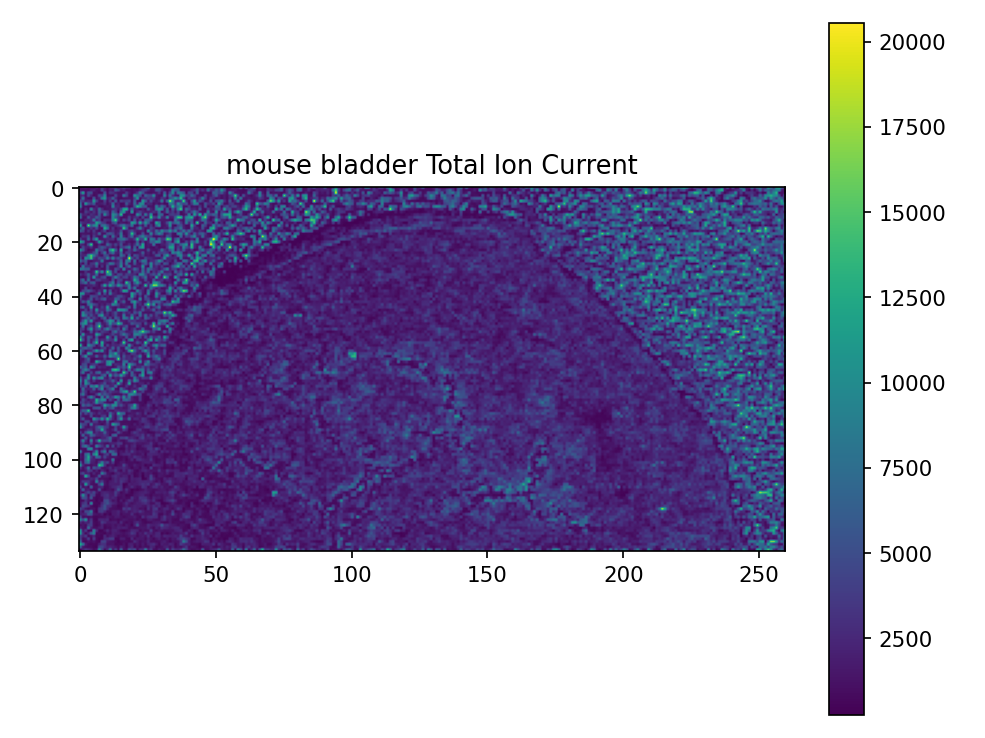

In [11]:
test_dataset = 'mouse bladder'
plt.figure()
plt.imshow(tic_arrays[test_dataset])
plt.title(test_dataset + ' Total Ion Current')
plt.colorbar()
plt.tight_layout()

Visualize example pixel spectra to check whether the data was loaded correctly:

In [12]:
# USER INPUT
test_dataset = 'mouse cerebellum'
test_coordinates = [
    (12, 5, 1),  # background in the mouse cerebellum image
    (53, 11, 1)  # tissue in the mouse cerebellum image
]
test_coordinate_names = ['Background', 'Tissue']

<IPython.core.display.Javascript object>


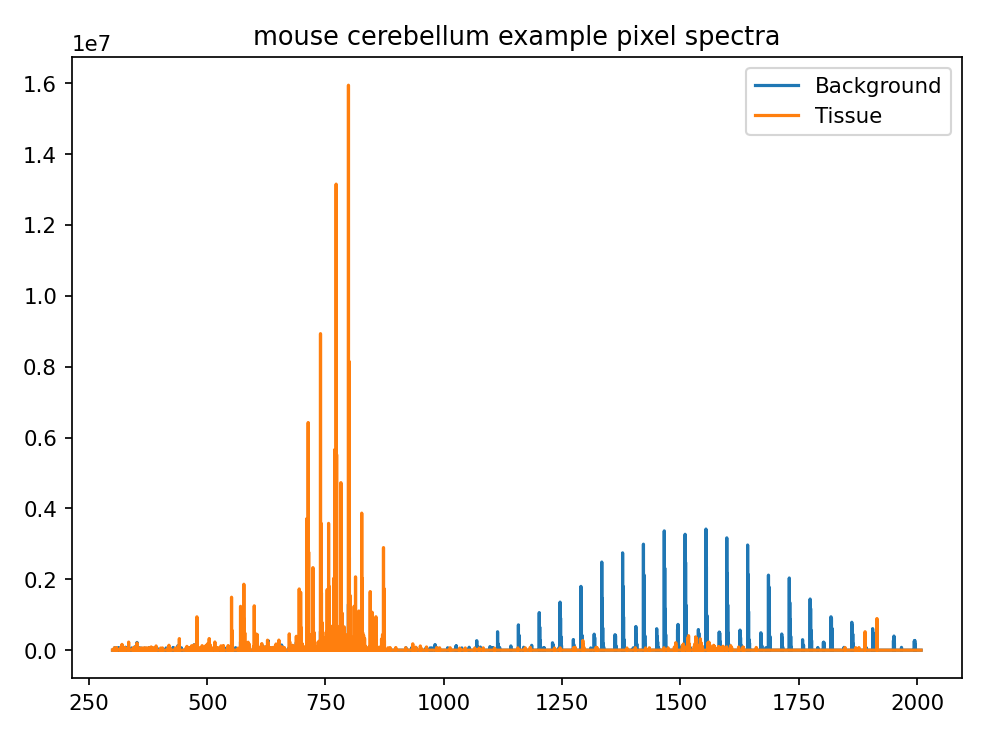

In [13]:
test_idx = [msi_datasets[test_dataset].coordinates.index(crd) for crd in test_coordinates]
plt.figure()
plt.plot(*msi_datasets[test_dataset].getspectrum(test_idx[0]))
plt.plot(*msi_datasets[test_dataset].getspectrum(test_idx[1]))
plt.legend(test_coordinate_names)
plt.title(test_dataset + ' example pixel spectra')
plt.tight_layout()

Inspect the histograms of total signals across the images to spot outliers (hotspots):

<IPython.core.display.Javascript object>


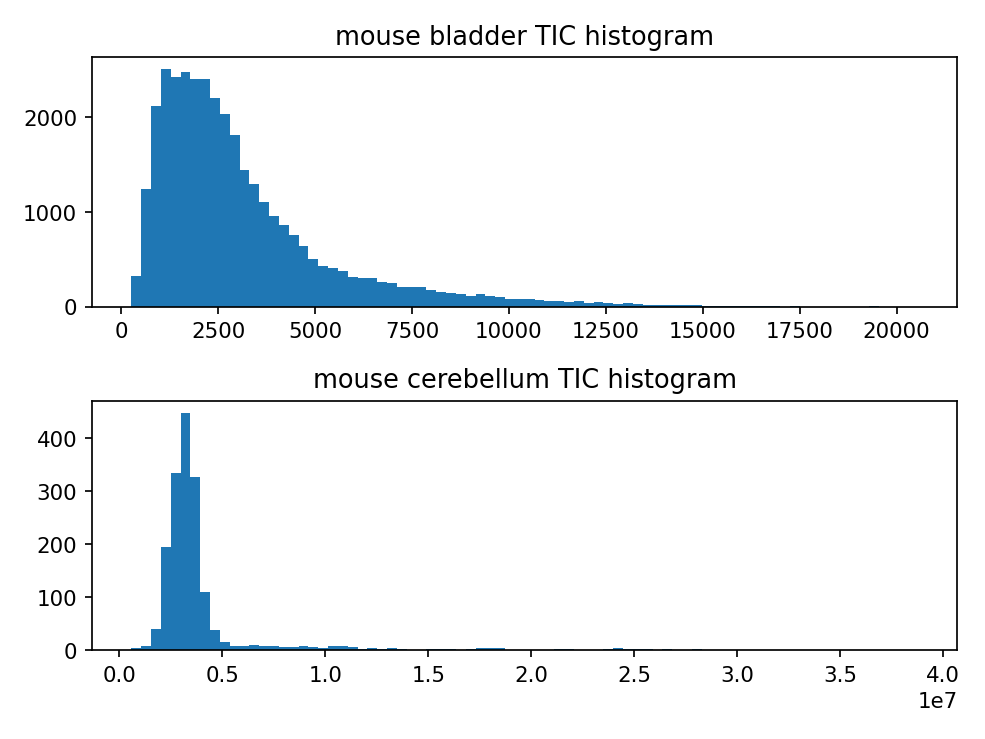

In [14]:
plt.figure()
for i, name in enumerate(msi_names):
    plt.subplot(len(msi_names), 1, 1 + i)
    plt.title(name + ' TIC histogram')
    plt.hist(tic_arrays[name].flatten(), bins=80)
plt.tight_layout()
plt.show()

# Summary spectra

In [15]:
from spatialstein.data_exploration import generate_summary_spectrum, plot_summary_spectrum

We'll generate summary spectra for the images to assess the overall distribution of intensities across the images. We can also identify m/z values with atypical spatial distribution.    

A summary spectrum is a spectrum showing the average intensity, its standard deviation, maximum value across the image, and the minimum value. We'll store it as a numpy array with four columns.   

Set a fixed mass axis for all spectra in the profile mode in order to create summary spectra.    
You can select a range of m/z values of interest.    
Note: the number of sampling points in the common mass axis (default `step=0.002`) should be selected so that it's not too memory-intensive, but also sufficiently high for an accurate centroiding.  
You can verify this in the next section of this notebook.  

In [16]:
# USER INPUT
analyzed_mass_range = (700, 900)
mass_axis_step = 0.002

In [17]:
mass_axis = np.arange(analyzed_mass_range[0], analyzed_mass_range[1], step=mass_axis_step)
print('Number of sampling points:', len(mass_axis))
print('Example points:', mass_axis[:10])

Number of sampling points: 100000
Example points: [700.    700.002 700.004 700.006 700.008 700.01  700.012 700.014 700.016
 700.018]


In [18]:
summary_spectra = {}
for name in msi_names:
    print('Processing data set', name)
    spectrum = generate_summary_spectrum(msi_datasets[name], tic_arrays[name], mass_axis)
    summary_spectra[name] = spectrum

Processing data set mouse bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Processing data set mouse cerebellum
Processing pixel number 0


Plot the summary spectra:

<IPython.core.display.Javascript object>


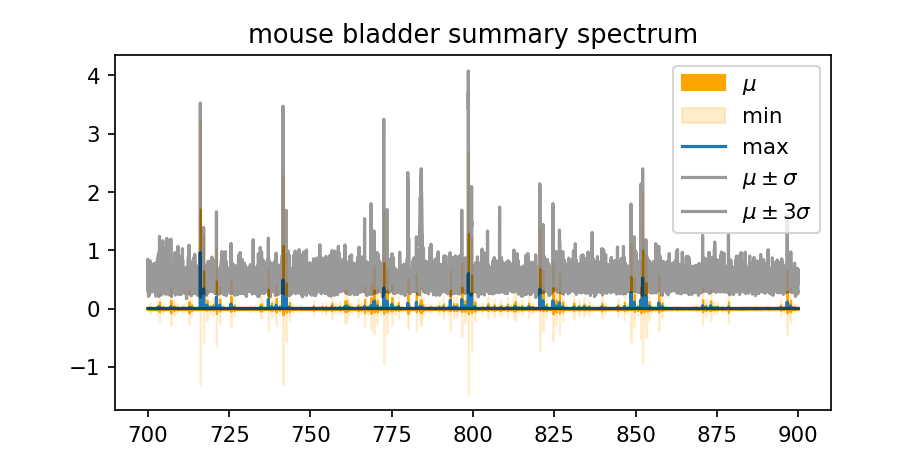

<IPython.core.display.Javascript object>


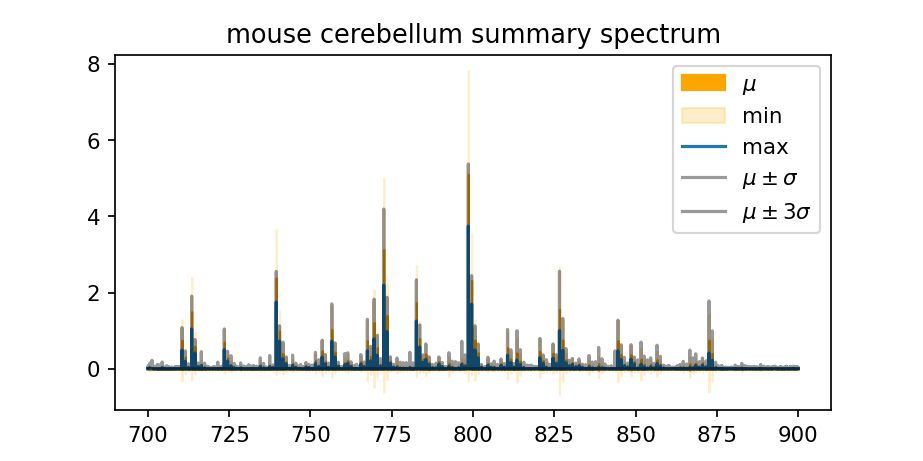

In [19]:
for name in msi_names:
    plot_summary_spectrum(mass_axis, 
                          summary_spectra[name], 
                          plot_title=name + ' summary spectrum', figsize=(6,3))

An alternative way of data exploration: Average and Skyline spectra.  
This is more commonly used but less informative. We will show an example for Mouse Cerebellum and Mouse Bladder data sets.    

<IPython.core.display.Javascript object>


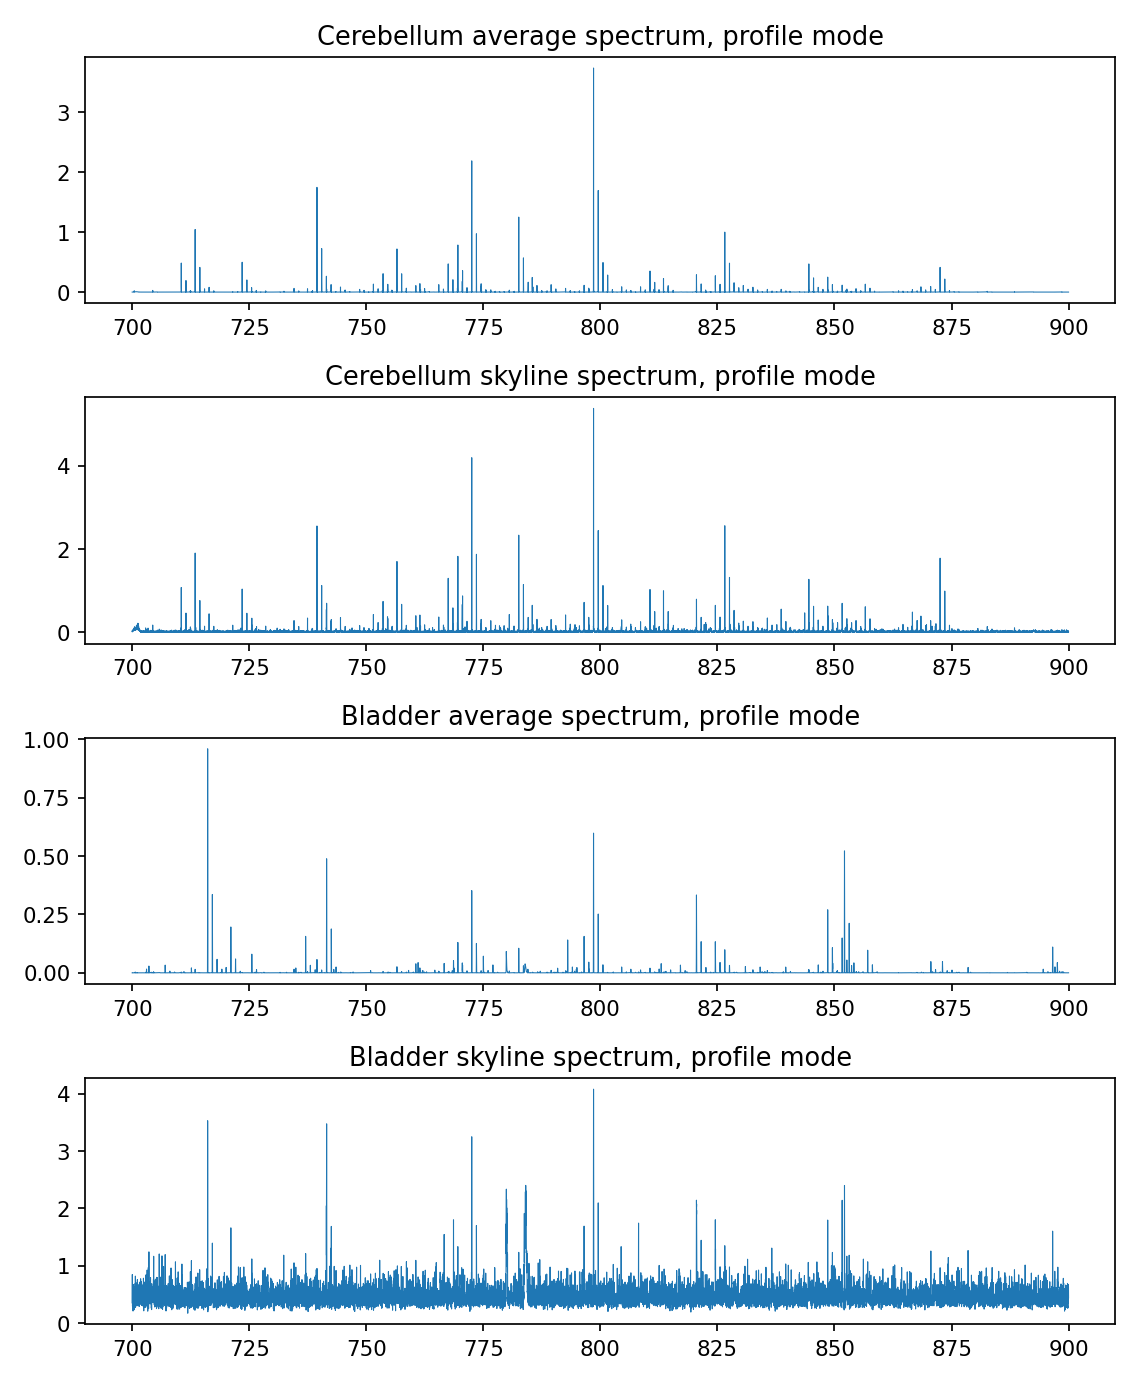

In [20]:
plt.subplots(4, 1, figsize=(7.4,9))
plt.subplot(411)
plt.plot(mass_axis, summary_spectra['mouse cerebellum'][:,0], lw=0.5)
plt.title('Cerebellum average spectrum, profile mode')

plt.subplot(412)
plt.plot(mass_axis, summary_spectra['mouse cerebellum'][:,3], lw=0.5)
plt.title('Cerebellum skyline spectrum, profile mode')

plt.subplot(413)
plt.plot(mass_axis, summary_spectra['mouse bladder'][:,0], lw=0.5)
plt.title('Bladder average spectrum, profile mode')

plt.subplot(414)
plt.plot(mass_axis, summary_spectra['mouse bladder'][:,3], lw=0.5)
plt.title('Bladder skyline spectrum, profile mode')

plt.tight_layout()

Save the summary spectra:

In [21]:
for name in msi_names:
    with open(OUTPUT_FOLDER / name + ' summary spectrum.tsv', 'w') as h:
        h.write('\t'.join(['m/z', 'Average', 'SD', 'min', 'max']) + '\n')
        for m, l in zip(mass_axis, summary_spectra[name]):
            h.write(str(m) + '\t' + '\t'.join(map(str, l))+'\n')

# Centroiding the average intensity spectra

In [22]:
from masserstein import Spectrum

We'll centroid the average spectra and save them in order to use in the lipid annotation stage.  
First, construct  `Spectrum` objects with the average spectra in profile modes.  

In [23]:
average_spectra = [Spectrum(confs=list(zip(mass_axis, summary_spectra[name][:,0]))) for name in summary_spectra]

Now, we need to set the parameters of the centroiding algorithm: the fraction of the apex height (typically 0.5 to centorid within the full width at half maximum), and the maximum width of the centroiding region (to avoid centroiding artifacts or baseline noise).  
Inspect the average spectra to set the latter parameter.  

For the mouse cerebellum example dataset, the base width of peaks at around 800 Da is approximately 0.07 Da. For  the bladder it's 0.09 Da. For a single, well-resolved peak, this is the maximum width regardless of the apex height fraction.      
However, we will increase it further to account for overlapping peaks and set a maximum width of a peak equal to 0.2 Da (approximately twice the base width). We'll assume that broader peaks are artifacts. For an example artifact, see e.g. the peak at 541.6 Da in the bladder summary spectrum - we don't want to centroid that.       

In [24]:
# USER INPUT
peak_height_fraction = 0.5
max_width = 0.2

In [25]:
centroids = [avg_sp.centroid(peak_height_fraction=peak_height_fraction, 
                             max_width=max_width)[0] for avg_sp in average_spectra]

Verify the centroiding. Construct `Spectrum` objects with centroided average spectra and plot them, overlayed with the average spectra in profile modes. For visualization purposes, we'll rescale the profile spectra so that the centroid heights match the peak heights rather than areas. The `scaling_factor` needs to be selected manually to obtain an optimal visual overlay of the two modes of the spectra. It depends on the resolving power of the spectrometer (i.e. the peak width in the profile spectrum).    

Note: centroid heights may not match apex heights exactly due to differences in peak widths. In particular, in many types of spectrometers, it is expected that centroid heights will be above apex heights for heavy masses and below them for low masses due to increasing peak widths.   

In [26]:
average_centroided = {name: Spectrum(confs=cntr_list) for cntr_list, name in zip(centroids, msi_names)}

In [27]:
# USER INPUT
scaling_factors={'mouse bladder': 0.03, 'mouse cerebellum': 0.015}

<IPython.core.display.Javascript object>


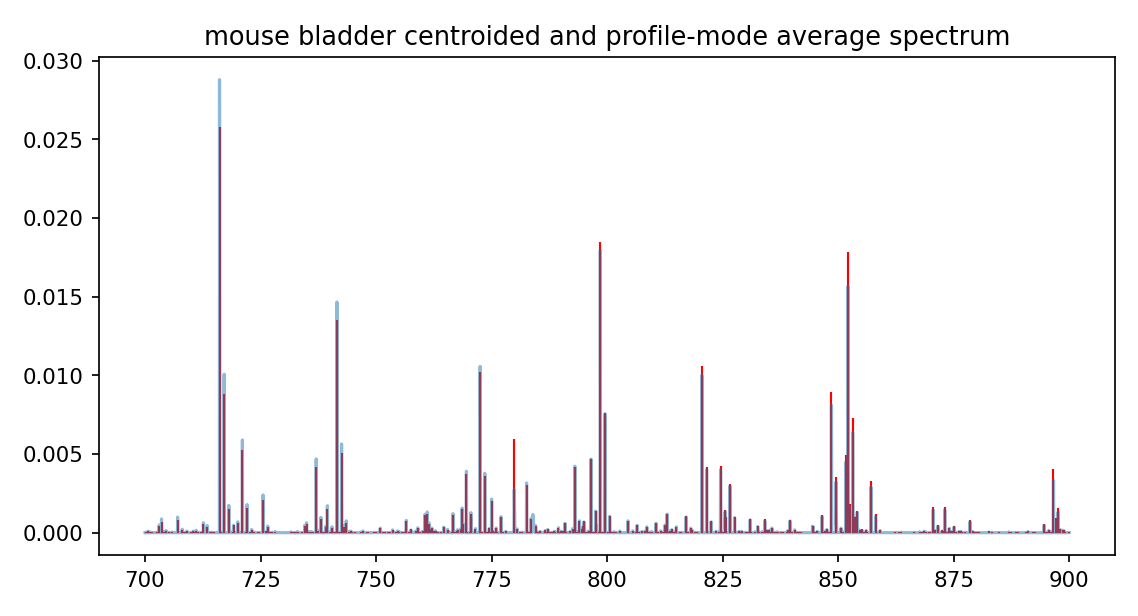

<IPython.core.display.Javascript object>


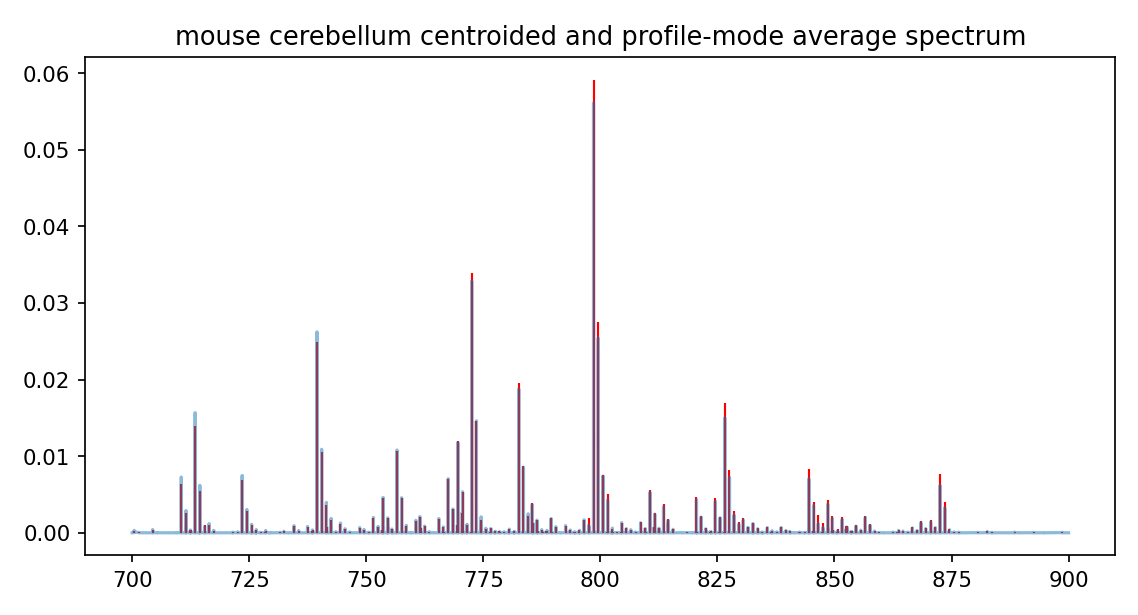

In [28]:
for name in msi_names:
    plt.figure(figsize=(7.4,4))
    plt.title(name + ' centroided and profile-mode average spectrum')
    average_centroided[name].plot(color='r', lw=1)
    plt.plot(mass_axis, summary_spectra[name][:,0]*scaling_factors[name], alpha=0.5)
    plt.tight_layout()

Save the centroided average spectra for annotation:

In [29]:
for i, n in enumerate(msi_names):
    with open(OUTPUT_FOLDER / n + ' centroided average spectrum.tsv', 'w') as h:
        h.write('\t'.join(['m/z', 'intsy']) + '\n')
        for m, l in centroids[i]:
            h.write(str(m) + '\t' + str(l)+'\n')

# Centroiding the data sets, saving the result

In [30]:
from spatialstein.data_preprocessing import centroid_and_save_msi_dataset

We'll centroid the pixel spectra of the images, using the same settings as for the average spectra.  
We'll save the results in an imzML file.  

Note that we won't restrict the mz values when centroiding the spectra to the mass range selected for summary spectra. This means we may include both heavier and lighter peaks than in the average spectrum. This is because we don't need to discard this information at this stage of the analysis. 

In [31]:
for name in msi_names:
    print('Processing data set', name)
    output_path = DATA_FOLDER / '%s centroided.imzML' % name  
    centroid_and_save_msi_dataset(msi_datasets[name], 
                                  output_path,
                                  peak_height_fraction = peak_height_fraction,
                                  max_width = max_width)

Processing data set mouse bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Processing data set mouse cerebellum
Processing pixel number 0


# Validating the centroiding results
Here we can test whether the file is saved properly and whether our centroiding worked.  


In [32]:
from spatialstein.data_exploration import centroided_ion_image, profile_ion_image

In [33]:
# USER INPUT
test_centroided_image = ImzMLParser('Data/mouse bladder centroided.imzML')
reference_profile_image = msi_datasets['mouse bladder']

We'll select a few test m/z values corresponding to known lipids. Then, we'll plot their ion images using both the unprocessed MS images and centroided MS images and we'll compare the results.  

In [34]:
# OPTIONAL USER INPUT
test_mzs = [772.523, 798.541, 848.556]
test_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']

In [35]:
profile_mode_images = []
centroided_mode_images = []
for mz in test_mzs:
    profile_mode_images.append(profile_ion_image(reference_profile_image, mz))
    centroided_mode_images.append(centroided_ion_image(test_centroided_image, mz))

Compare the images

<IPython.core.display.Javascript object>


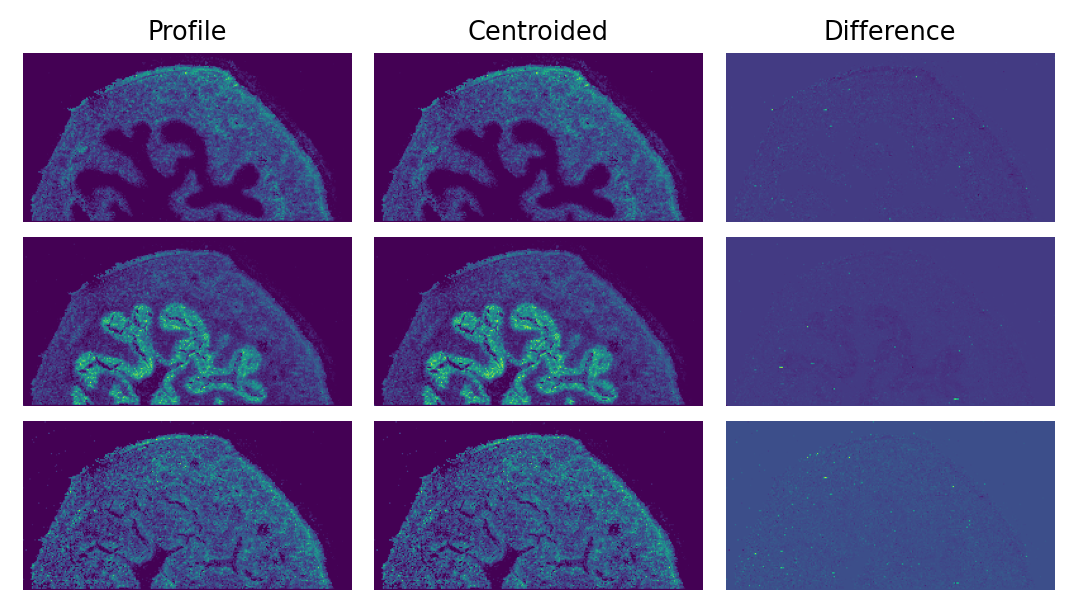

In [36]:
plt.figure(figsize=(7, 4))
plt.subplot(3, 3, 1)
plt.title('Profile')
plt.subplot(3, 3, 2)
plt.title('Centroided')
plt.subplot(3, 3, 3)
plt.title('Difference')
for i, n in enumerate(test_names):
    pim = profile_mode_images[i]
    cim = centroided_mode_images[i]
    plt.subplot(3, 3, 1+3*i)
    plt.imshow(pim)
    plt.axis('off')
    plt.subplot(3, 3, 2+3*i)
    plt.imshow(cim)
    plt.axis('off')
    plt.subplot(3, 3, 3+3*i)
    plt.imshow(pim/np.sum(pim) - cim/np.sum(cim))
    plt.axis('off')
plt.tight_layout()

The spatial distributions in the profile and centroided images should be visually almost identical. The difference should be distributed mostly randomly, indicating that the differences between profile and centroided images are mostly due to numerical processing and confirming a correct centroiding.  

Inspect selected spectra:

In [37]:
# USER INPUT
test_coordinates = (220, 3, 1)

In [38]:
test_idx = [
    reference_profile_image.coordinates.index(test_coordinates), 
    test_centroided_image.coordinates.index(test_coordinates)
]

In [39]:
test_profile = Spectrum(confs=list(zip(*reference_profile_image.getspectrum(test_idx[0]))))
test_centroided = Spectrum(confs=list(zip(*test_centroided_image.getspectrum(test_idx[1]))))

In [40]:
# USER INPUT
scaling_factor = 0.03

<IPython.core.display.Javascript object>


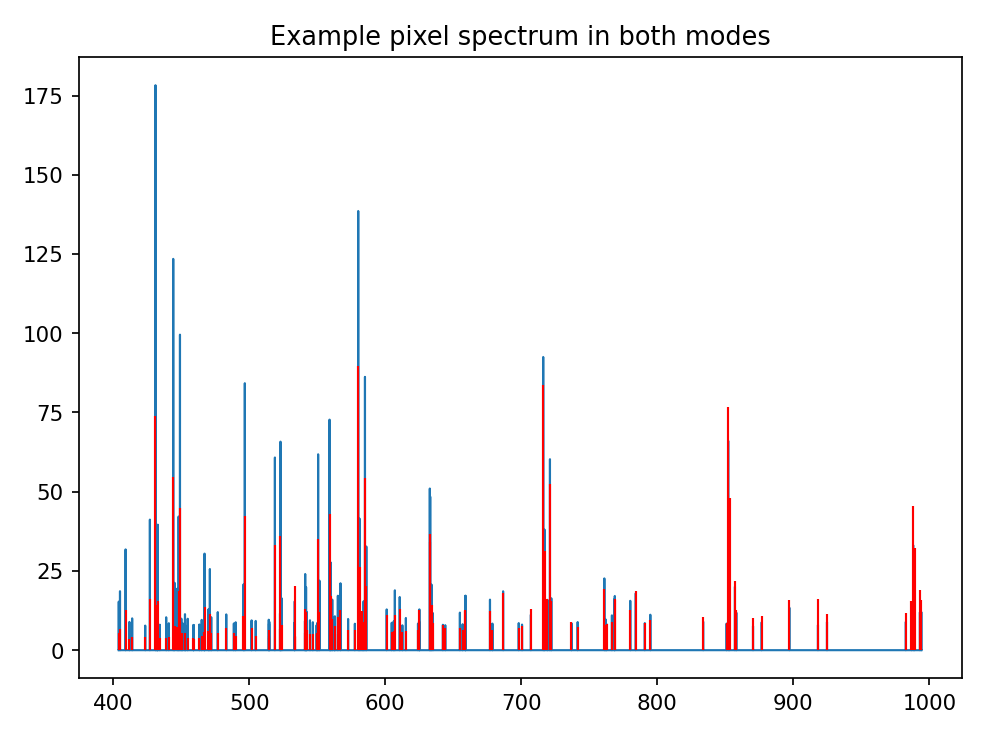

In [41]:
plt.figure()
(scaling_factor*test_profile).plot(profile=True)
test_centroided.plot(color='r')
plt.title('Example pixel spectrum in both modes')
plt.tight_layout()

As with the centroided average spectrum, in most spectrometers we expect a shift in the relative heights of centroided intensities and profile-mode apex heights due to an increasing peak width.    
Be aware that pixel spectra may be more noisy and less detailed than average spectra, among other factors because of a possibly lower sampling of the mass axis (i.e. less m/z measurement points, making the profile spectra possibly rugged). Therefore, you may observe more differences between the spectra in profile and centroided modes.    